In [1]:
spark

StatementMeta(, , , SessionStarting, )

## Reading in Libraries and Importing Data

In [2]:
## Necessary Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import *
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from tabulate import tabulate

from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder, IndexToString
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator, RegressionEvaluator
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
from pyspark.ml import PipelineModel


StatementMeta(, , , Waiting, )

In [3]:
# Read in data using spark
workspace_default_storage_account = "aml6214727930"
workspace_default_container = "azureml-blobstore-6653633b-3460-4381-9199-d9e0f368353c"

workspace_wasbs_base_url = (
    f"wasbs://{workspace_default_container}@{workspace_default_storage_account}.blob.core.windows.net/"
)

comments_path = "/basketball_comments_clean_v2.parquet"
comments_sentiment_path = "/basketball_comments_sentiment.parquet"

comments = spark.read.parquet(f"{workspace_wasbs_base_url}{comments_path}")
comments_sentiment = spark.read.parquet(f"{workspace_wasbs_base_url}{comments_sentiment_path}")

StatementMeta(, , , Waiting, )

In [4]:
# Merge comments and sentiment dataframe to get sentiment on same line for each comment
comments = comments.join(comments_sentiment.select("id", "col", "clean_text"), on="id", how='inner')
comments = comments.cache()

StatementMeta(, , , Waiting, )

## Prepare Dataframe for Modeling

In [5]:
comments = comments.filter(col("subreddit")=="CollegeBasketball") # keep only CollegeBasketball Subreddit
comments = comments.withColumn("hour", hour("created_utc")) # create hour column
comments = comments.withColumn("comment_length", length("body")) # create comment length column
comments = comments.withColumnRenamed("col", "sentiment") # rename "col" to "sentiment"
comments = comments.withColumn("supports_a_team", when(col("supported_team").isNull(), 0).otherwise(1)) # define binary variable for if an author has a supported team in their profile
# count number of posts by each author and create column (Used GAI for these two lines prompt: for each unique entry in the "author" column count how many times that entry existsw in the dataset and create a new column with that value for each author)
window_spec = Window.partitionBy("author")  # GAI
comments = comments.withColumn("author_activity", F.count("author").over(window_spec)) # GAI

StatementMeta(, , , Waiting, )

In [120]:
score = comments.select("score").toPandas()
stats_table = score["score"].describe()
print("         Summary Statistics for 'Score' (Upvotes-Downvotes) Variable")
print(tabulate(pd.DataFrame(stats_table).T, headers='keys', tablefmt='fancy_grid'))

StatementMeta(d3c1b951-094c-48e1-919d-e32bc175397b, 48, 125, Finished, Available)

         Summary Statistics for 'Score' (Upvotes-Downvotes) Variable
╒═══════╤═════════╤═════════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╕
│       │   count │    mean │   std │   min │   25% │   50% │   75% │   max │
╞═══════╪═════════╪═════════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╡
│ score │  865472 │ 9.19509 │ 39.91 │  -341 │     1 │     3 │     7 │  5360 │
╘═══════╧═════════╧═════════╧═══════╧═══════╧═══════╧═══════╧═══════╧═══════╛


StatementMeta(d3c1b951-094c-48e1-919d-e32bc175397b, 48, 126, Finished, Available)

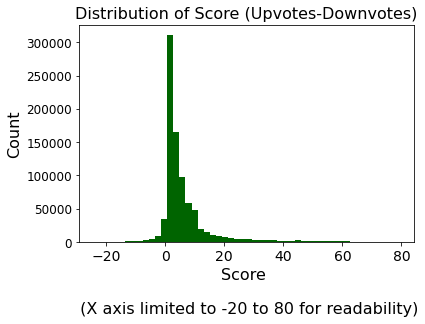

In [121]:
score["score_limit"] = score["score"][(score["score"]<80) & (score["score"]>-25)]
plt.hist(score["score_limit"], bins = 50, color="darkgreen")
plt.title("Distribution of Score (Upvotes-Downvotes)", fontsize = 16)
plt.xlabel('Score \n\n (X axis limited to -20 to 80 for readability)', fontsize = 16)
plt.ylabel('Count', fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 12)
plt.savefig("Users/vankempenklaas/fall-2023-reddit-project-team-26/data/plots/ml_q1_score_dist.png")
plt.show()

Split data into training and testing (80/20) with start seed

In [8]:
train_data, test_data = comments.randomSplit([0.8, 0.2], seed = 82)
print("Number of training records: " + str(train_data.count()))
print("Number of testing records : " + str(test_data.count()))
train_data = train_data.cache()

StatementMeta(d3c1b951-094c-48e1-919d-e32bc175397b, 49, 19, Finished, Available)

Number of training records: 692440
Number of testing records : 172760


### Regression

Attempt to predict score of a comment (popularity) based on the following: 

- If the author has a supported team in their profile picture
- What month the post is from
- What the sentiment of the post is
- What Year the post is from
- What day the post is from
- What Hour of day the post is from
- Length of the post
- How much the author has commented in this dataset

In [10]:
# perform variable transformations for categorical/binary variables
stringIndexer_team = StringIndexer(inputCol='supports_a_team', outputCol="team_index", handleInvalid="skip") 
stringIndexer_month = StringIndexer(inputCol='month', outputCol="month_index", handleInvalid="skip") 
stringIndexer_sentiment = StringIndexer(inputCol='sentiment', outputCol="sentiment_index", handleInvalid="skip") 
onehot_sentiment = OneHotEncoder(inputCol="sentiment_index", outputCol="sentiment_vec")
onehot_month = OneHotEncoder(inputCol="month_index", outputCol="month_vec")

StatementMeta(d3c1b951-094c-48e1-919d-e32bc175397b, 49, 21, Finished, Available)

In [11]:
# assemble all features using vector assembler 
feature_cols = ['comment_length', 'day', 'year', 'hour', 'author_activity', "month_vec", "sentiment_vec", "team_index"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

StatementMeta(d3c1b951-094c-48e1-919d-e32bc175397b, 49, 22, Finished, Available)

In [12]:
# define random forest model 
rf = RandomForestRegressor(featuresCol="features", labelCol="score", maxDepth=5, numTrees=50)

StatementMeta(d3c1b951-094c-48e1-919d-e32bc175397b, 49, 23, Finished, Available)

In [13]:
# define pipeline model 
pipeline_model = Pipeline(stages = [
    stringIndexer_sentiment,
    stringIndexer_month,
    stringIndexer_team,
    onehot_month,
    onehot_sentiment,
    assembler,
    rf
])

StatementMeta(d3c1b951-094c-48e1-919d-e32bc175397b, 49, 24, Finished, Available)

In [14]:
# fit the pipelined model using the training data
model = pipeline_model.fit(train_data)

StatementMeta(d3c1b951-094c-48e1-919d-e32bc175397b, 49, 25, Finished, Available)

In [15]:
# save the model
model.write().overwrite().save("Users/vankempenklaas/fall-2023-reddit-project-team-26/code/ml/model_files/popularity_model_v1")

StatementMeta(d3c1b951-094c-48e1-919d-e32bc175397b, 49, 26, Finished, Available)

In [16]:
# load the saved trained model
loaded_model = PipelineModel.load("Users/vankempenklaas/fall-2023-reddit-project-team-26/code/ml/model_files/popularity_model_v1")

StatementMeta(d3c1b951-094c-48e1-919d-e32bc175397b, 49, 27, Finished, Available)

In [17]:
# make predictions using the saved model on the test data
predictions = loaded_model.transform(test_data)

StatementMeta(d3c1b951-094c-48e1-919d-e32bc175397b, 49, 28, Finished, Available)

In [117]:
# evaluate the model using RMSE 
evaluator = RegressionEvaluator(labelCol="score", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = {:.2f}".format(rmse))

StatementMeta(d3c1b951-094c-48e1-919d-e32bc175397b, 48, 122, Finished, Available)

Root Mean Squared Error (RMSE) on test data = 37.55


In [18]:
# downsample the predictions to get ~10,000 rows to visualize 
predictions_df = predictions.sample(fraction = 0.07, seed = 92).select("prediction").toPandas()
true_labels_df = predictions.sample(fraction = 0.07, seed = 92).select("score").toPandas()

StatementMeta(d3c1b951-094c-48e1-919d-e32bc175397b, 49, 29, Finished, Available)

StatementMeta(d3c1b951-094c-48e1-919d-e32bc175397b, 49, 31, Finished, Available)

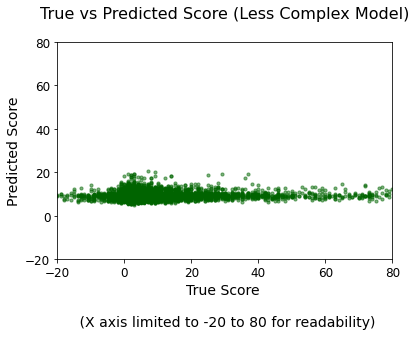

In [20]:
# plot true values against predicted values
plt.scatter(true_labels_df, predictions_df, alpha=0.5, s = 10, c = ["darkgreen"])
plt.title("True vs Predicted Score (Less Complex Model)\n", fontsize = 16)
plt.xlabel("True Score \n\n (X axis limited to -20 to 80 for readability)", fontsize = 14)
plt.ylabel("Predicted Score", fontsize = 14)
plt.ylim([-20,80])
plt.xlim([-20,80])
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.savefig("Users/vankempenklaas/fall-2023-reddit-project-team-26/data/plots/ml_q1_simplemodel_plot.png")
plt.show()

#### Version 2

Increasing the number of trees in the random forest from 50 to 200 to give the model more complexity. Also increasing the max depth from 5 to 10 to increase complexity as well. 

In [21]:
rf_v2 = RandomForestRegressor(featuresCol="features", labelCol="score", maxDepth=10, numTrees=200)

StatementMeta(d3c1b951-094c-48e1-919d-e32bc175397b, 49, 32, Finished, Available)

In [22]:
pipeline_model_v2 = Pipeline(stages = [
    stringIndexer_sentiment,
    stringIndexer_month,
    stringIndexer_team,
    onehot_month,
    onehot_sentiment,
    assembler,
    rf_v2
])

StatementMeta(d3c1b951-094c-48e1-919d-e32bc175397b, 49, 33, Finished, Available)

In [23]:
model_v2 = pipeline_model_v2.fit(train_data)

StatementMeta(d3c1b951-094c-48e1-919d-e32bc175397b, 49, 34, Finished, Available)

In [24]:
model_v2.write().overwrite().save("Users/vankempenklaas/fall-2023-reddit-project-team-26/code/ml/model_files/popularity_model_v2")

StatementMeta(d3c1b951-094c-48e1-919d-e32bc175397b, 49, 35, Finished, Available)

In [25]:
loaded_model_v2 = PipelineModel.load("Users/vankempenklaas/fall-2023-reddit-project-team-26/code/ml/model_files/popularity_model_v2")

StatementMeta(d3c1b951-094c-48e1-919d-e32bc175397b, 49, 36, Finished, Available)

In [26]:
test_predictions = loaded_model_v2.transform(test_data)
train_predictions = loaded_model_v2.transform(train_data)

StatementMeta(d3c1b951-094c-48e1-919d-e32bc175397b, 49, 37, Finished, Available)

In [96]:
evaluator = RegressionEvaluator(labelCol="score", predictionCol="prediction", metricName="rmse")
test_rmse = evaluator.evaluate(test_predictions)
train_rmse = evaluator.evaluate(train_predictions)
print("Root Mean Squared Error (RMSE) on test data = {:.2f}".format(test_rmse))
print("Root Mean Squared Error (RMSE) on train data = {:.2f}".format(train_rmse))

StatementMeta(d3c1b951-094c-48e1-919d-e32bc175397b, 48, 101, Finished, Available)

Root Mean Squared Error (RMSE) on test data = 37.25
Root Mean Squared Error (RMSE) on train data = 39.33


In [27]:
predictions_df = test_predictions.sample(fraction = 0.07, seed = 92).select("prediction").toPandas()
true_labels_df = test_predictions.sample(fraction = 0.07, seed = 92).select("score").toPandas()

StatementMeta(d3c1b951-094c-48e1-919d-e32bc175397b, 49, 38, Finished, Available)

StatementMeta(d3c1b951-094c-48e1-919d-e32bc175397b, 49, 39, Finished, Available)

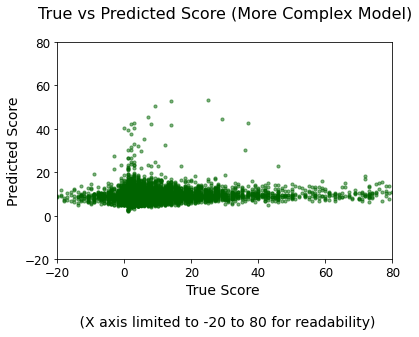

In [28]:
# plot true values against predicted values
plt.scatter(true_labels_df, predictions_df, alpha=0.5, s = 10, c = ["darkgreen"])
plt.title("True vs Predicted Score (More Complex Model)\n", fontsize = 16)
plt.xlabel("True Score \n\n (X axis limited to -20 to 80 for readability)", fontsize = 14)
plt.ylabel("Predicted Score", fontsize = 14)
plt.ylim([-20,80])
plt.xlim([-20,80])
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.savefig("Users/vankempenklaas/fall-2023-reddit-project-team-26/data/plots/ml_q1_complexmodel_plot.png")
plt.show()

In [110]:
importances = loaded_model_v2.stages[-1].featureImportances

var_imp = pd.DataFrame(list(zip(feature_cols, importances)),columns=['feature', 'importance'])
var_imp.sort_values(by = "importance", ascending=False, inplace=True)
print(" Complex Model Feature Importance")
print(tabulate(var_imp.set_index("feature"), headers='keys', tablefmt='fancy_grid'))

StatementMeta(d3c1b951-094c-48e1-919d-e32bc175397b, 48, 115, Finished, Available)

 Complex Model Feature Importance
╒═════════════════╤══════════════╕
│ feature         │   importance │
╞═════════════════╪══════════════╡
│ comment_length  │   0.21808    │
├─────────────────┼──────────────┤
│ author_activity │   0.203866   │
├─────────────────┼──────────────┤
│ hour            │   0.203269   │
├─────────────────┼──────────────┤
│ day             │   0.184356   │
├─────────────────┼──────────────┤
│ month_vec       │   0.0172099  │
├─────────────────┼──────────────┤
│ team_index      │   0.0103959  │
├─────────────────┼──────────────┤
│ sentiment_vec   │   0.00865863 │
├─────────────────┼──────────────┤
│ year            │   0.00547859 │
╘═════════════════╧══════════════╛
